In [18]:
import os
from bs4 import BeautifulSoup, NavigableString, Tag 

from nltk.util import ngrams
from nltk import word_tokenize

import json
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib as plt
import seaborn as sns

import collections
import csv

from datetime import datetime
from pytz import timezone

print "imported"

imported


In [19]:
# IMPORTS SPECIFIC TO TOPIC MODELING

import langid
import nltk
import re
import time
from collections import defaultdict
from configparser import ConfigParser
from gensim import corpora, models, similarities
from nltk.tokenize import RegexpTokenizer
from string import digits
print "imported"

imported


In [5]:
df = pd.read_csv('prison_talk_il.csv')
df.head(10)

,date,post_id,user,post_body
0,03-21-2005 11:42 AM,t-113714-1,Morrigan68,I would like to get started compiling informat...
1,03-23-2005 12:33 AM,t-113714-2,CET,I have visited at Stateville Lawrence and Cent...
2,03-27-2005 07:44 PM,t-113714-3,valorie1,Tamms: RE: Visiting- you must get a perspectiv...
3,03-28-2005 12:07 AM,t-113714-4,CET,Dress code: They determine it while you are th...
4,04-04-2005 05:54 PM,t-113714-5,iqyou,Hi my name is Michele and I have never posted ...
5,04-08-2005 01:46 AM,t-113714-6,KristinGish,Hi. This is my first post here. My husband is ...
6,04-12-2005 09:09 AM,t-113714-7,eddyswife39,My husband is in Sheridan. He just got sentenc...
7,04-25-2005 07:42 AM,t-113714-8,CET,I think it would be helpful to get input from ...
8,05-05-2005 05:47 PM,t-113714-9,CET,I would like to have another thread with a sti...
9,05-23-2006 11:09 AM,t-113714-10,boosmom,Do you still need info on Hill Correctional in...


In [6]:
df['thread_id'] = df['post_id'].str.split('-').str.get(1)
cols = df.columns.tolist()
cols = [cols[0]] + [cols[-1]] + cols[1:4]
df = df[cols]
df.head(10)

,date,thread_id,post_id,user,post_body
0,03-21-2005 11:42 AM,113714,t-113714-1,Morrigan68,I would like to get started compiling informat...
1,03-23-2005 12:33 AM,113714,t-113714-2,CET,I have visited at Stateville Lawrence and Cent...
2,03-27-2005 07:44 PM,113714,t-113714-3,valorie1,Tamms: RE: Visiting- you must get a perspectiv...
3,03-28-2005 12:07 AM,113714,t-113714-4,CET,Dress code: They determine it while you are th...
4,04-04-2005 05:54 PM,113714,t-113714-5,iqyou,Hi my name is Michele and I have never posted ...
5,04-08-2005 01:46 AM,113714,t-113714-6,KristinGish,Hi. This is my first post here. My husband is ...
6,04-12-2005 09:09 AM,113714,t-113714-7,eddyswife39,My husband is in Sheridan. He just got sentenc...
7,04-25-2005 07:42 AM,113714,t-113714-8,CET,I think it would be helpful to get input from ...
8,05-05-2005 05:47 PM,113714,t-113714-9,CET,I would like to have another thread with a sti...
9,05-23-2006 11:09 AM,113714,t-113714-10,boosmom,Do you still need info on Hill Correctional in...


In [7]:
df.head()

,date,thread_id,post_id,user,post_body
0,03-21-2005 11:42 AM,113714,t-113714-1,Morrigan68,I would like to get started compiling informat...
1,03-23-2005 12:33 AM,113714,t-113714-2,CET,I have visited at Stateville Lawrence and Cent...
2,03-27-2005 07:44 PM,113714,t-113714-3,valorie1,Tamms: RE: Visiting- you must get a perspectiv...
3,03-28-2005 12:07 AM,113714,t-113714-4,CET,Dress code: They determine it while you are th...
4,04-04-2005 05:54 PM,113714,t-113714-5,iqyou,Hi my name is Michele and I have never posted ...


In [8]:
print 'UNIQUE THREADS:', len(df['thread_id'].unique())
print 'UNIQUE POSTS:', len(df['post_id'])
print 'UNIQUE USERS:', len(df['user'].unique())

UNIQUE THREADS: 296
UNIQUE POSTS: 2109
UNIQUE USERS: 634


In [9]:
df['user'].value_counts(sort=True)[:25]

downtownchicago    77
Miss_A             73
Patty              57
jiggysgirl         56
herewithoutyou2    44
heisRfamily2       41
blah8705           41
MiniMoose          39
seagrtj            39
JaiDan             38
26thncaliswag      32
chris idoc         31
wolcat             31
MobPrincess        29
bigmuddy           29
rhewsbbgurl        25
Kemo'sWife         24
adamsrubberduck    24
jennnshane1999     23
reetz              19
Rostonhall         17
daveswifey6        16
Jillian            16
yourself           16
cher50             15
Name: user, dtype: int64

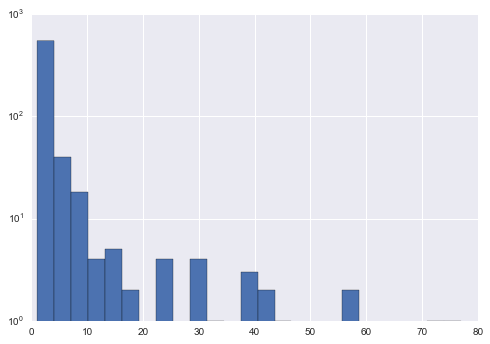

In [10]:
df['user'].value_counts(sort=True).hist(log=True, bins=25)

In [11]:
df['post_body'].fillna(' ', inplace = True)

In [12]:
# http://stackoverflow.com/questions/17841149/pandas-groupby-how-to-get-a-union-of-strings
threaded = df.groupby(['thread_id'])['post_body'].agg(lambda col : ' '.join(col))

In [13]:
documents = threaded.tolist()

In [14]:
# for doc in documents[:5]:
#     print doc
#     print ''

### Pre-processing

In [15]:
# CODE HELP FROM:
# https://github.com/alexperrier/datatalks/blob/master/twitter/twitter_preprocessing.py

# SPLITS EACH POST INTO WORDS WHILE REMOVING PUNCTUATION (\w+) AND LOWER CASES THEM A WORD SUCH AS
# I'M WILL BECOME I, M
tokenizer = RegexpTokenizer(r'\w+')
documents = [ tokenizer.tokenize(doc.lower()) for doc in documents ]
## [['what', 'do', 'they', 'look', 'for', 'for', 'approval', 'or', 'denial'],
##  ['hi','i','m','wondering','if','someone','could','answer',...]...
# documents[:2]

In [16]:
# I'M NOT SURE THESE ARE TECHNICALLY UNIGRAMS AND BIGRAMS SO MUCH AS THEY ARE SINGLE LETTER WORDS
# AND TWO LETTER WORDS BUT WHO AM I TO JUDEGE (SHULDER SHURG)

# ['i','m','a','a','i','t','6',...]
unigrams = [ w for doc in documents for w in doc if len(w)==1]
# ['do','or','or','of','be',...]
bigrams  = [ w for doc in documents for w in doc if len(w)==2]

misc = ['get', 'know', 'would']

# print unigrams[:5]
# print bigrams[:5]

In [17]:
# CREATES THE SET OF UNIQUE "CUSTOM STOP LIST WITH NLTK + THE ABOVE
stoplist  = set(nltk.corpus.stopwords.words("english") + unigrams + bigrams + misc)

# REMOVES STOP WORDS
documents = [[token for token in doc if token not in stoplist]
                for doc in documents]

# REMOVES WORDS THAT ARE NUMBERS ONLY
documents = [ [token for token in doc if len(token.strip(digits)) == len(token)]
                for doc in documents ]

# # [['look', 'approval', 'denial', 'parole', 'approval'...],
# # ['wondering', 'someone', 'could', 'answer', 'question'...]...]
# print documents[0][:5]
# print documents[1][:5]

LookupError: 
**********************************************************************
  Resource u'corpora/stopwords' not found.  Please use the NLTK
  Downloader to obtain the resource:  >>> nltk.download()
  Searched in:
    - '/Users/bsugar/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************

In [14]:
# REMOVE WORDS THAT OCCUR ONLY ONCE
token_frequency = defaultdict(int)

# count all tokens
for doc in documents:
    for token in doc:
        token_frequency[token] += 1

# keep words that occur more than once
documents = [ [token for token in doc if token_frequency[token] > 1]
                for doc in documents  ]

# Sort words in documents
for doc in documents:
    doc.sort()
    
## [['approval', 'approval', 'approval', 'approval', 'approval'...],
##  ['answer', 'benefit', 'benefit', 'benefit', 'confused'...]...]

# print documents[0][:5]
# print documents[1][:5]

In [15]:
# I HATE UNICODE!!
documents = [ [token.decode('ascii', 'ignore') for token in doc] for doc in documents  ]

In [16]:
# Build a dictionary where for each document each word has its own id
dictionary = corpora.Dictionary(documents)
dictionary.compactify()
# and save the dictionary for future use
dictionary.save('prison_talk_nyc_no_misc.dict')

In [18]:
# We now have a dictionary with 11127 unique tokens
# Dictionary(11127 unique tokens: [u'foul', u'narcotic', u'four', u'woods', u'hanging']...)
# print dictionary

In [19]:
# Build the corpus: vectors with occurence of each word for each document
# convert tokenized documents to vectors
corpus = [dictionary.doc2bow(doc) for doc in documents]

In [20]:
# and save in Market Matrix format
corpora.MmCorpus.serialize('prison_talk_nyc_no_misc.mm', corpus)
# this corpus can be loaded with corpus = corpora.MmCorpus('prison_talk_nyc.mm')